The ground Hatree-Fock state is when 1up and 1down orbitals (molecular orbitals) are occupied. This is (1, 1, 0, 0) in fermion occupation basis. In Bravyi-Kitaev basis, this is (1, 0, 0, 0), so just X(0). 

In [1]:
from openfermion.ops import FermionOperator
from openfermion.transforms import jordan_wigner, bravyi_kitaev
from openfermion.utils import hermitian_conjugated
from openfermion.utils import uccsd_generator
import numpy as np

from pyquil.paulis import PauliSum
from pyquil.api import WavefunctionSimulator
from scipy.optimize import minimize
from pyquil import Program
from pyquil.gates import *

from openfermion.ops import QubitOperator
from forestopenfermion import pyquilpauli_to_qubitop, qubitop_to_pyquilpauli
from forestopenfermion import exponentiate

import numpy as np
import functools

from openfermion.hamiltonians import MolecularData, load_molecular_hamiltonian

In [9]:
sim = WavefunctionSimulator()
numQubit = 4
class Track:
    def __init__(self):
        self.cnt = 0


def solve_vqe_ucc_h2(hamiltonian: PauliSum, degree) -> float:
    # Construct a variational quantum eigensolver solution to find the lowest
    # eigenvalue of the given hamiltonian
    
    # degree 1: up to T_1
    # degree 2: up to T_2
    
    numParams = 0
    if degree == 1:
        numParams = 2
    elif degree == 2:
        numParams = 3
    params_init = np.random.rand(numParams)*0.5-0.25
    
    track = Track()

    def inc(t, xk):
        t.cnt += 1
    
    def ansatz_energy(params):
        p = None
        p = Program()
        
        # Reference state
        p += X(0)
        
        single_amp = []
        double_amp = []
        
        # occupied: 0,1 unoccupied: 2,3
        single_amp.append([[2,0], params[0]])
        single_amp.append([[3,1], params[1]])
        
        if degree >= 2:
            double_amp.append([[2,0,3,1], params[2]])
        
        ucc_gen = uccsd_generator(single_amp, double_amp)
        ucc_gen_qubitop = bravyi_kitaev(ucc_gen)
        try:
            ucc_program = exponentiate(ucc_gen_qubitop/(-1j))
        except:
            ucc_program = I(0)
        p += ucc_program

        energy = sim.expectation(p, hamiltonian).real
        return energy

    params_answer = minimize(ansatz_energy, params_init, method='L-BFGS-B', callback=functools.partial(inc, track)).x
    return ansatz_energy(params_answer), track.cnt

In [3]:
def get_ground_energy_ucc_h2(interaction_hamil, degree):
    fermionop_hamil = FermionOperator()
    for key in interaction_hamil:
        value = interaction_hamil[key]
        fermionop_hamil += FermionOperator(term=key, coefficient=value)
        
    qubitop_hamil = bravyi_kitaev(fermionop_hamil)
    pauliop_hamil = qubitop_to_pyquilpauli(qubitop_hamil)
    
    sim = WavefunctionSimulator()
    return solve_vqe_ucc_h2(pauliop_hamil, degree)


In [10]:
basis = 'sto-3g'
multiplicity = 1  # 2S+1
charge = 0

import matplotlib.pyplot as plt
%matplotlib inline

bond_lengths = np.linspace(0.3, 2.5, 23)
vqe_ground_energies_mean = []
vqe_ground_energies_std = []
vqe_iter_mean = []
vqe_iter_std = []

for degree in [1,2]:
    gelist = []
    gestdlist = []
    iterlist = []
    iterstdlist = []
    for bond_length in bond_lengths:
        geometry = [('H', (0., 0., 0.)), ('H', (0., 0., bond_length))]
        description = str(round(bond_length, 2))
        h2_interaction_hamil = load_molecular_hamiltonian(geometry,
            basis,
            multiplicity,
            description,
            n_active_electrons=None,
            n_active_orbitals=None)

        gelist_temp = []
        iterlist_temp = []
        for i in range(5):
            ge, cnt = get_ground_energy_ucc_h2(h2_interaction_hamil, degree)
            print('bond length: ', round(bond_length, 2), ' ground state energy: ', ge, ' iteration: ', cnt)
            gelist_temp.append(ge)
            iterlist_temp.append(cnt)
        gelist.append(np.mean(gelist_temp))
        gestdlist.append(np.std(gelist_temp))
        iterlist.append(np.mean(iterlist_temp))
        iterstdlist.append(np.std(iterlist_temp))
        
    vqe_ground_energies_mean.append(gelist)
    vqe_ground_energies_std.append(gestdlist)
    vqe_iter_mean.append(np.mean(iterlist))
    vqe_iter_std.append(np.mean(iterstdlist))


bond length:  0.3  ground state energy:  -0.593827764584893  iteration:  4
bond length:  0.3  ground state energy:  -0.5938277645835948  iteration:  4
bond length:  0.3  ground state energy:  -0.5938277645847605  iteration:  4
bond length:  0.3  ground state energy:  -0.5938277645828329  iteration:  4
bond length:  0.3  ground state energy:  -0.5938277645848051  iteration:  4
bond length:  0.4  ground state energy:  -0.9043613977138403  iteration:  4
bond length:  0.4  ground state energy:  -0.9043613977138454  iteration:  4
bond length:  0.4  ground state energy:  -0.9043613977137395  iteration:  4
bond length:  0.4  ground state energy:  -0.9043613977137921  iteration:  4
bond length:  0.4  ground state energy:  -0.9043613977135462  iteration:  4
bond length:  0.5  ground state energy:  -1.0429962764996603  iteration:  4
bond length:  0.5  ground state energy:  -1.0429962765072092  iteration:  4
bond length:  0.5  ground state energy:  -1.0429962765071874  iteration:  4
bond length: 

bond length:  2.4  ground state energy:  -0.9341589091962414  iteration:  7
bond length:  2.4  ground state energy:  -0.9341589091991955  iteration:  9
bond length:  2.5  ground state energy:  -0.9338672031059146  iteration:  10
bond length:  2.5  ground state energy:  -0.9338672031060943  iteration:  10
bond length:  2.5  ground state energy:  -0.9338672031043663  iteration:  8
bond length:  2.5  ground state energy:  -0.9338672031052259  iteration:  7
bond length:  2.5  ground state energy:  -0.9338672031007271  iteration:  10
bond length:  0.3  ground state energy:  -0.6018037168161834  iteration:  6
bond length:  0.3  ground state energy:  -0.6018037168348078  iteration:  7
bond length:  0.3  ground state energy:  -0.6018037168224861  iteration:  6
bond length:  0.3  ground state energy:  -0.6018037168334625  iteration:  6
bond length:  0.3  ground state energy:  -0.6018037168352947  iteration:  7
bond length:  0.4  ground state energy:  -0.914149708214112  iteration:  6
bond lengt

bond length:  2.3  ground state energy:  -0.9389223857875447  iteration:  12
bond length:  2.3  ground state energy:  -0.938922385610885  iteration:  14
bond length:  2.3  ground state energy:  -0.9389223833093678  iteration:  13
bond length:  2.3  ground state energy:  -0.9389223856624692  iteration:  15
bond length:  2.4  ground state energy:  -0.9372549528595133  iteration:  16
bond length:  2.4  ground state energy:  -0.9372549525242031  iteration:  12
bond length:  2.4  ground state energy:  -0.9372549528581303  iteration:  14
bond length:  2.4  ground state energy:  -0.9372549528459975  iteration:  10
bond length:  2.4  ground state energy:  -0.937254952786271  iteration:  10
bond length:  2.5  ground state energy:  -0.9360549198422001  iteration:  13
bond length:  2.5  ground state energy:  -0.9360549198404993  iteration:  12
bond length:  2.5  ground state energy:  -0.9360549197448144  iteration:  16
bond length:  2.5  ground state energy:  -0.9360549196914036  iteration:  11
b

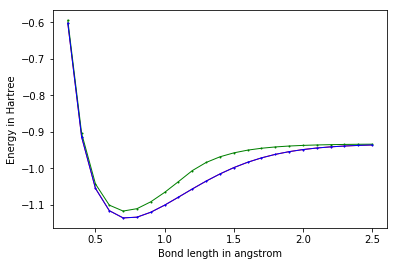

In [11]:
# Set molecule parameters.
basis = 'sto-3g'
multiplicity = 1

# Generate molecule at different bond lengths.
hf_energies = []
fci_energies = []
bond_lengths = []
for bond_length in np.linspace(0.3, 2.5, 23):
    bond_lengths += [bond_length]
    description = str(round(bond_length,2))
#    print(description)
    geometry = [('H', (0., 0., 0.)), ('H', (0., 0., bond_length))]
    molecule = MolecularData(
        geometry, basis, multiplicity, description=description)
    
    # Load data.
    molecule.load()
    fci_energies += [molecule.fci_energy]

plt.figure(0)
plt.plot(bond_lengths, fci_energies, 'rx-', linewidth=1, markersize=1)
plt.plot(bond_lengths, vqe_ground_energies_mean[0], 'go-', linewidth=1, markersize=1)
plt.plot(bond_lengths, vqe_ground_energies_mean[1], 'bo-', linewidth=1, markersize=1)
plt.ylabel('Energy in Hartree')
plt.xlabel('Bond length in angstrom')
plt.show()

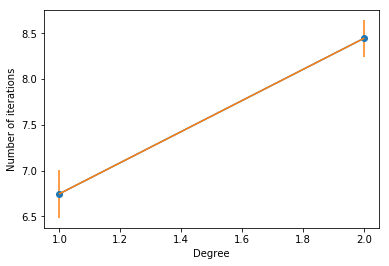

[6.747826086956521, 8.443478260869567]
[0.26379483 0.19821515]


In [19]:
plt.plot([1,2], vqe_iter_mean, 'o-')
plt.errorbar([1,2], vqe_iter_mean, vqe_iter_std/np.sqrt(23))
plt.ylabel('Number of iterations')
plt.xlabel('Degree')
plt.show()
print(vqe_iter_mean)
print(vqe_iter_std/np.sqrt(23))

In [15]:
print(max(max(vqe_ground_energies_std)))

9.614377221744849e-10


[0.9776784174233513, 0.9999999999412992]


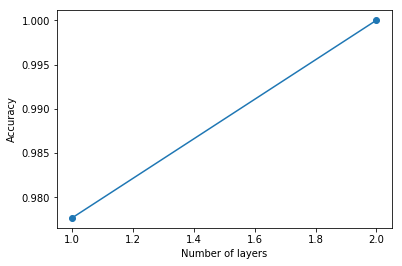

In [16]:
accuracy = []
for i in range(2):
    acc = 1-np.mean(np.array(vqe_ground_energies_mean[i])-np.array(fci_energies))
    accuracy.append(acc)
print(accuracy)
plt.plot([1,2], accuracy, 'o-')
plt.ylabel('Accuracy')
plt.xlabel('Number of layers')
plt.show()